In [1]:
import numpy as np
import pandas as pd
from wrangle import wrangle_zillow
from wrangle import tts_con
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import sklearn.preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import QuantileTransformer

In [2]:
zillow=wrangle_zillow()
zillow.head()

,bedroom_count,bathroom_count,calc_finished_square_ft,tax_value_dollar_count,year_built,tax_amount,fips_code
0,4.0,2.0,3633.0,296425.0,2005.0,6941.39,6037.0
1,3.0,4.0,1620.0,847770.0,2011.0,10244.94,6037.0
2,3.0,2.0,2077.0,646760.0,1926.0,7924.68,6037.0
3,0.0,0.0,1200.0,5328.0,1972.0,91.60,6037.0
4,0.0,0.0,171.0,6920.0,1973.0,255.17,6037.0


In [3]:
zillow.isnull().sum()

bedroom_count              0
bathroom_count             0
calc_finished_square_ft    0
tax_value_dollar_count     0
year_built                 0
tax_amount                 0
fips_code                  0
dtype: int64

In [4]:
zillow.select_dtypes('number')

,bedroom_count,bathroom_count,calc_finished_square_ft,tax_value_dollar_count,year_built,tax_amount,fips_code
0,4.0,2.0,3633.0,296425.0,2005.0,6941.39,6037.0
1,3.0,4.0,1620.0,847770.0,2011.0,10244.94,6037.0
2,3.0,2.0,2077.0,646760.0,1926.0,7924.68,6037.0
3,0.0,0.0,1200.0,5328.0,1972.0,91.60,6037.0
4,0.0,0.0,171.0,6920.0,1973.0,255.17,6037.0
...,...,...,...,...,...,...,...
2140230,4.0,4.0,4375.0,422400.0,2015.0,13877.56,6037.0
2140231,4.0,3.0,2262.0,960756.0,2015.0,13494.52,6059.0
2140232,4.0,4.5,3127.0,536061.0,2014.0,6244.16,6059.0
2140233,3.0,2.5,1974.0,424353.0,2015.0,5302.70,6059.0


# visualize columns

bedroom_count


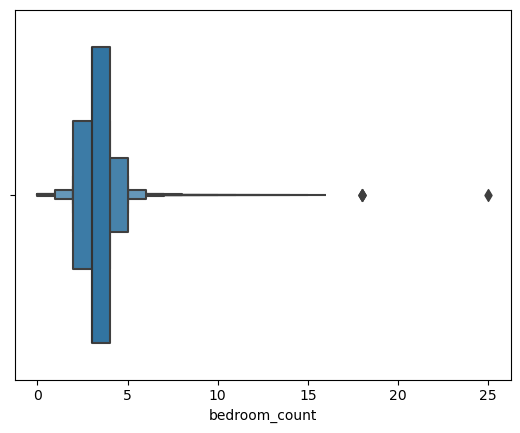

bathroom_count


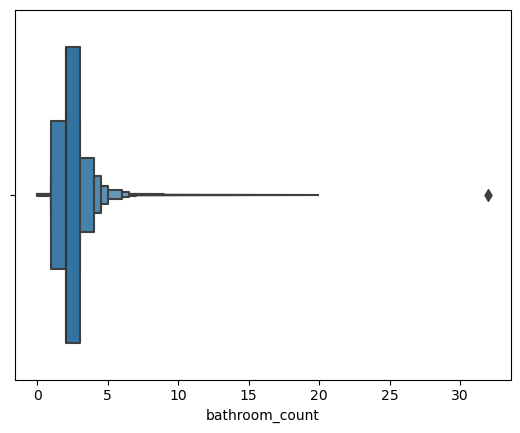

calc_finished_square_ft


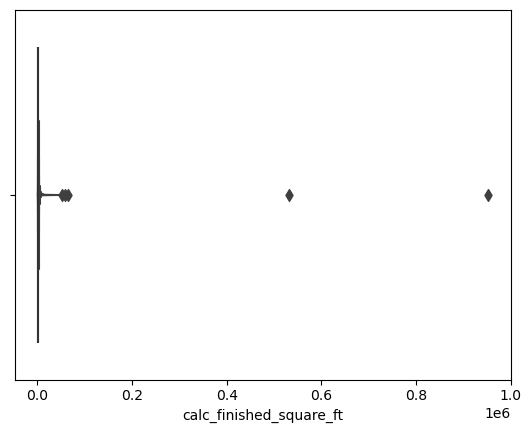

tax_value_dollar_count


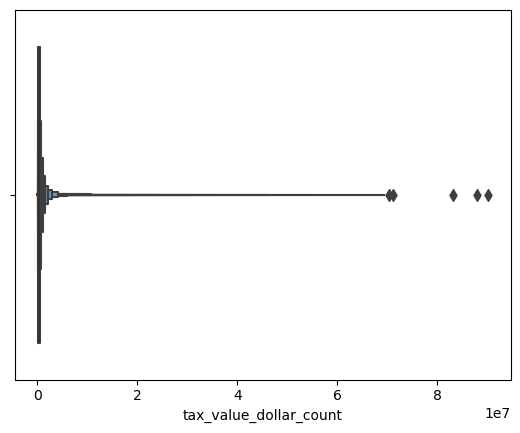

year_built


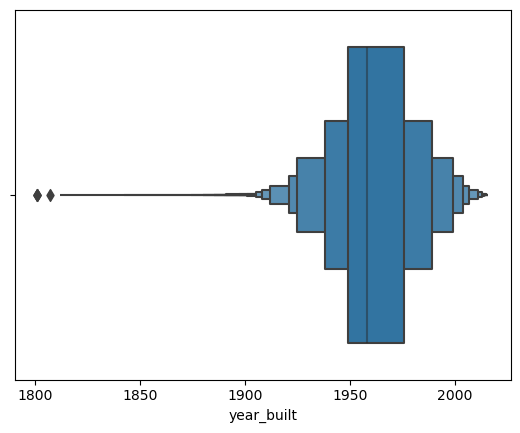

tax_amount


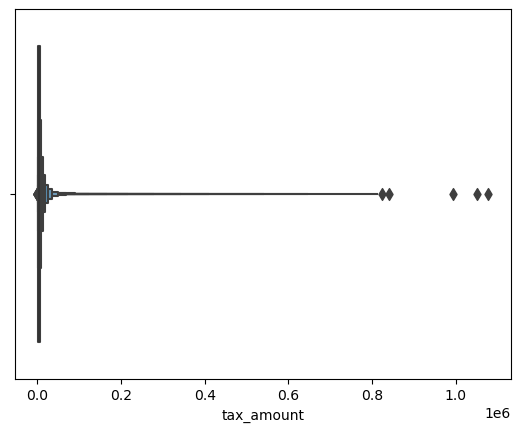

fips_code


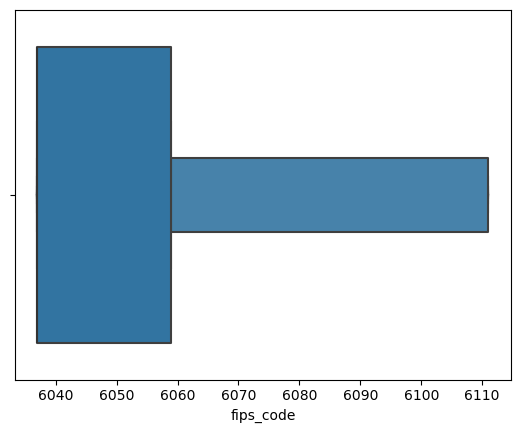

In [5]:
for col in zillow:
    print(col)
    sns.boxenplot(x = col, data= zillow)
    plt.show()

# Identify and remove outliers before splitting and scaling

In [6]:
a=[]
b=[]
fences=[a, b]
features= []
for col in zillow:
        if zillow[col].dtype == 'float' or zillow[col].dtype == 'int':
            '''
            for each feature find the first and third quartile
            '''
            q1, q3 = zillow[col].quantile([.25, .75])
            '''
            calculate inter quartile range
            '''
            iqr = q3 - q1
            '''
            calculate the upper and lower fence
            '''
            upper_fence = q3 + (1.5 * iqr)
            lower_fence = q1 - (1.5 * iqr)
            '''
            appending the upper and lower fences to lists
            '''
            a.append(upper_fence)
            b.append(lower_fence)
            '''
            appending the feature names to a list
            '''
            features.append(col)
            '''
            assigning the fences and feature names to a dataframe
            '''
            var_fences= pd.DataFrame(fences, columns=features, index=['upper_fence', 'lower_fence'])
        else:
            print(col)
            print('column is not a float or int')

## Quartile fences for determining outliers

In [7]:
var_fences

,bedroom_count,bathroom_count,calc_finished_square_ft,tax_value_dollar_count,year_built,tax_amount,fips_code
upper_fence,5.5,4.5,3633.0,1052766.0,2016.5,12218.55,6092.0
lower_fence,1.5,0.5,-167.0,-328994.0,1908.5,-3265.77,6004.0


In [8]:
zillow['fips_code'].nunique()

3

## Make a function to identify and remove outliers and deliver a dataframe of the fences like above

In [9]:
def remove_outliers(df, k=1.5):
    a=[]
    b=[]
    fences=[a, b]
    features= []
    col_list = df.columns.tolist()
    i=0
    for col in df:
            new_df=np.where(df[col].nunique()>8, True, False)
            if new_df==True:
                if df[col].dtype == 'float' or df[col].dtype == 'int':
                    '''
                    for each feature find the first and third quartile
                    '''
                    q1, q3 = df[col].quantile([.25, .75])
                    '''
                    calculate inter quartile range
                    '''
                    iqr = q3 - q1
                    '''
                    calculate the upper and lower fence
                    '''
                    upper_fence = q3 + (k * iqr)
                    lower_fence = q1 - (k * iqr)
                    '''
                    appending the upper and lower fences to lists
                    '''
                    a.append(upper_fence)
                    b.append(lower_fence)
                    '''
                    appending the feature names to a list
                    '''
                    features.append(col)
                    '''
                    assigning the fences and feature names to a dataframe
                    '''
                    var_fences= pd.DataFrame(fences, columns=features, index=['upper_fence', 'lower_fence'])
                else:
                    print(col)
                    print('column is not a float or int')
            else:
                print(f'{col} column ignored')
                                    
    for col in col_list[:6]:
        df = df[(df[col]<= a[i]) & (df[col]>= b[i])]
        i+=1
    return df, var_fences


## checking original and removed outlier describes to see if it worked

In [10]:
zillow_filtered, fences= remove_outliers(zillow)
zillow_filtered.describe().T

fips_code column ignored


,count,mean,std,min,25%,50%,75%,max
bedroom_count,1893641.0,3.231233,0.786047,2.00,3.00,3.0,4.00,5.00
bathroom_count,1893641.0,2.085427,0.725158,0.50,2.00,2.0,2.50,4.50
calc_finished_square_ft,1893641.0,1685.065362,595.205958,1.00,1240.00,1566.0,2029.00,3633.00
tax_value_dollar_count,1893641.0,343291.593779,216090.009031,22.00,178496.00,304726.0,469008.00,1052753.00
year_built,1893641.0,1960.283478,20.250137,1909.00,1950.00,1958.0,1973.00,2016.00
tax_amount,1893641.0,4253.629203,2455.919136,16.48,2422.48,3842.0,5681.44,12218.53
fips_code,1893641.0,6048.448244,20.571897,6037.00,6037.00,6037.0,6059.00,6111.00


In [11]:
zillow.describe().T

,count,mean,std,min,25%,50%,75%,max
bedroom_count,2140235.0,3.301419,0.932600,0.00,3.00,3.00,4.00,25.00
bathroom_count,2140235.0,2.240352,0.990549,0.00,2.00,2.00,3.00,32.00
calc_finished_square_ft,2140235.0,1863.193970,1221.754161,1.00,1258.00,1623.00,2208.00,952576.00
tax_value_dollar_count,2140235.0,460641.625164,677157.635675,22.00,189166.00,328296.00,534606.00,90188462.00
year_built,2140235.0,1960.967545,22.150563,1801.00,1949.00,1958.00,1976.00,2016.00
tax_amount,2140235.0,5616.711322,7814.562798,6.34,2540.85,4111.47,6411.93,1078101.87
fips_code,2140235.0,6048.309556,20.344910,6037.00,6037.00,6037.00,6059.00,6111.00


In [12]:
fences

,bedroom_count,bathroom_count,calc_finished_square_ft,tax_value_dollar_count,year_built,tax_amount
upper_fence,5.5,4.5,3633.0,1052766.0,2016.5,12218.55
lower_fence,1.5,0.5,-167.0,-328994.0,1908.5,-3265.77


# Exercises begin here

In [16]:
z_train, z_val, z_test = tts_con(zillow_filtered)
scale_feats= z_train[['bedroom_count', 'bathroom_count', 'calc_finished_square_ft', 'tax_amount']]

In [14]:
#Apply the scalers we talked about in this lesson to your data 
#and visualize the results for the unscaled and scaled distribution.
mm_scaler= MinMaxScaler()

Text(0.5, 1.0, 'Scaled')

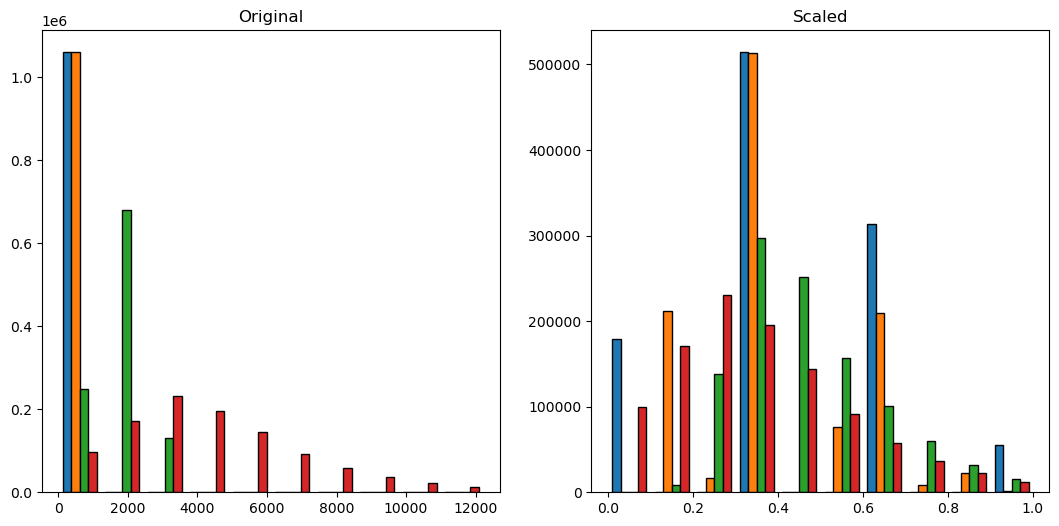

In [19]:
mm_scaler.fit(scale_feats)

scale_feats_scaled = mm_scaler.transform(scale_feats)

plt.figure(figsize=(13, 6))
plt.subplot(121)
plt.hist(scale_feats, bins=10, ec='black')
plt.title('Original')
plt.subplot(122)
plt.hist(scale_feats_scaled, bins=10, ec='black')
plt.title('Scaled')

Text(0.5, 1.0, 'Scaled')

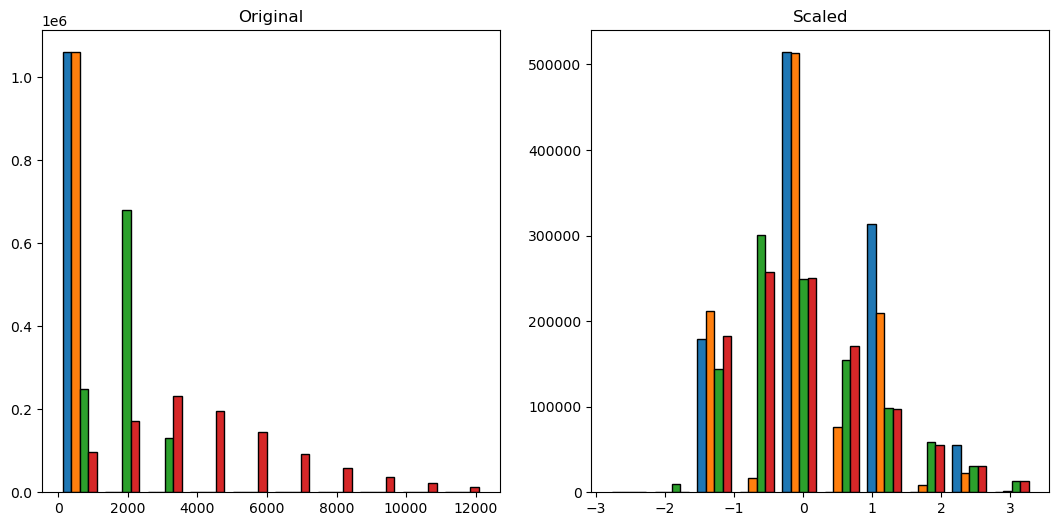

In [20]:
ss_scaler = sklearn.preprocessing.StandardScaler()

ss_scaler.fit(scale_feats)

scale_feats_scaled = ss_scaler.transform(scale_feats)


plt.figure(figsize=(13, 6))
plt.subplot(121)
plt.hist(scale_feats, bins=10, ec='black')
plt.title('Original')
plt.subplot(122)
plt.hist(scale_feats_scaled, bins=10, ec='black')
plt.title('Scaled')

Text(0.5, 1.0, 'Scaled')

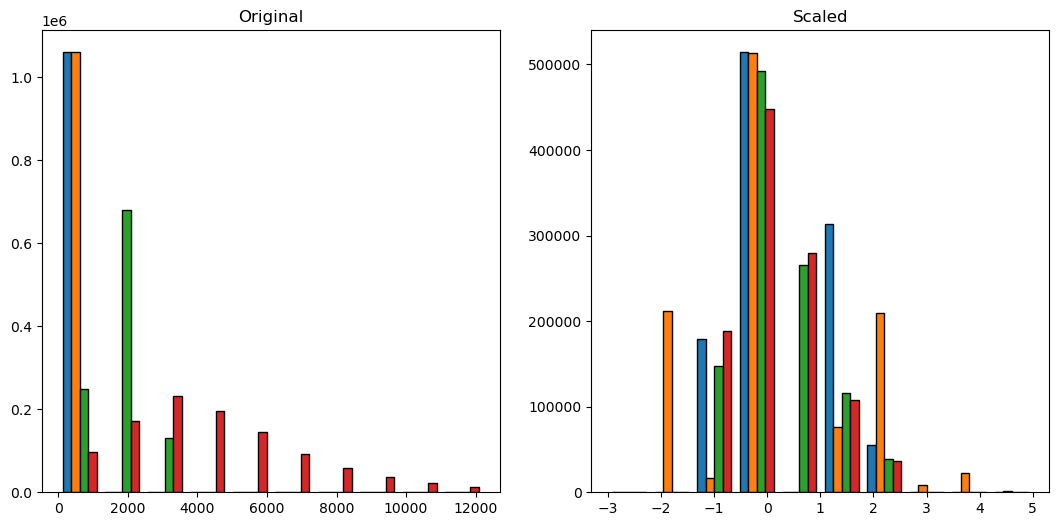

In [21]:
rs_scaler = sklearn.preprocessing.RobustScaler()

rs_scaler.fit(scale_feats)

scale_feats_scaled = rs_scaler.transform(scale_feats)

plt.figure(figsize=(13, 6))
plt.subplot(121)
plt.hist(scale_feats, bins=10, ec='black')
plt.title('Original')
plt.subplot(122)
plt.hist(scale_feats_scaled, bins=10, ec='black')
plt.title('Scaled')

Text(0.5, 1.0, 'Scaled')

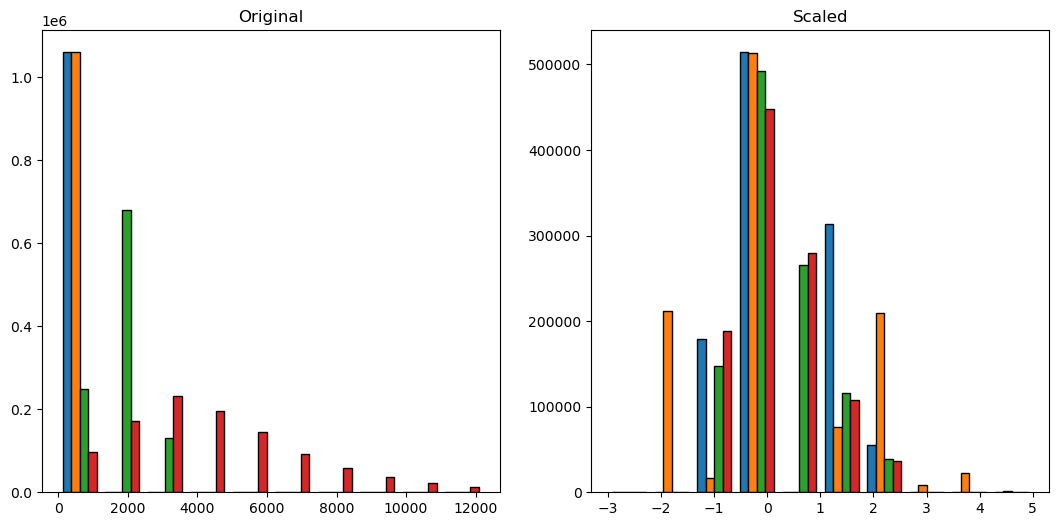

In [22]:
#Apply the .inverse_transform method to your scaled data. 
#Is the resulting dataset the exact same as the original data?

scale_feats_scaled_i = rs_scaler.transform(scale_feats)

plt.figure(figsize=(13, 6))
plt.subplot(121)
plt.hist(scale_feats, bins=10, ec='black')
plt.title('Original')
plt.subplot(122)
plt.hist(scale_feats_scaled_i, bins=10, ec='black')
plt.title('Scaled')

#looks the same as before it was inversed

Text(0.5, 1.0, 'Scaled')

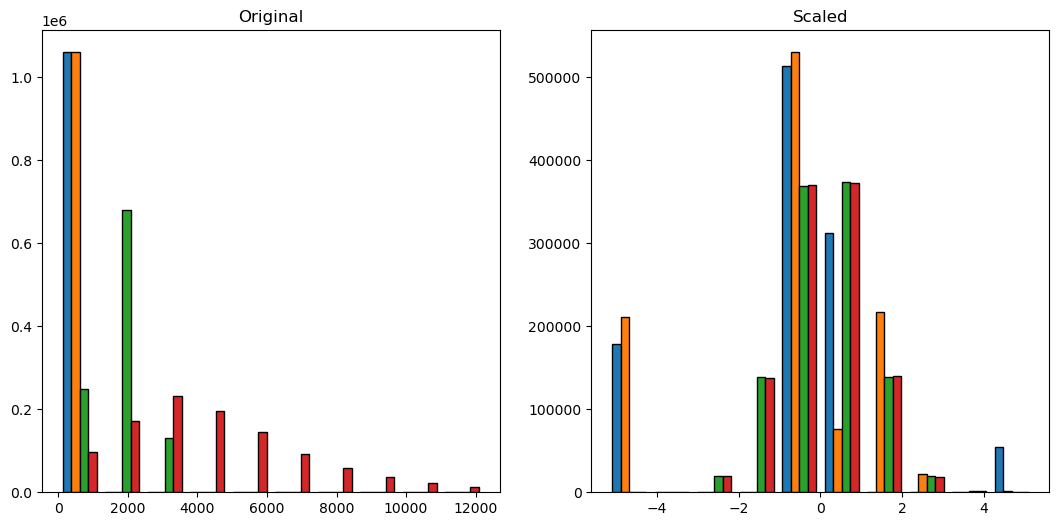

In [23]:
#Read the documentation for sklearn's QuantileTransformer. 
#Use normal for the output_distribution and apply this scaler to your data. 
#Visualize the result of your data scaling.

qt_scaler=QuantileTransformer(output_distribution='normal')

qt_scaler.fit(scale_feats)

scale_feats_scaled = qt_scaler.transform(scale_feats)

plt.figure(figsize=(13, 6))
plt.subplot(121)
plt.hist(scale_feats, bins=10, ec='black')
plt.title('Original')
plt.subplot(122)
plt.hist(scale_feats_scaled, bins=10, ec='black')
plt.title('Scaled')

Text(0.5, 1.0, 'Scaled')

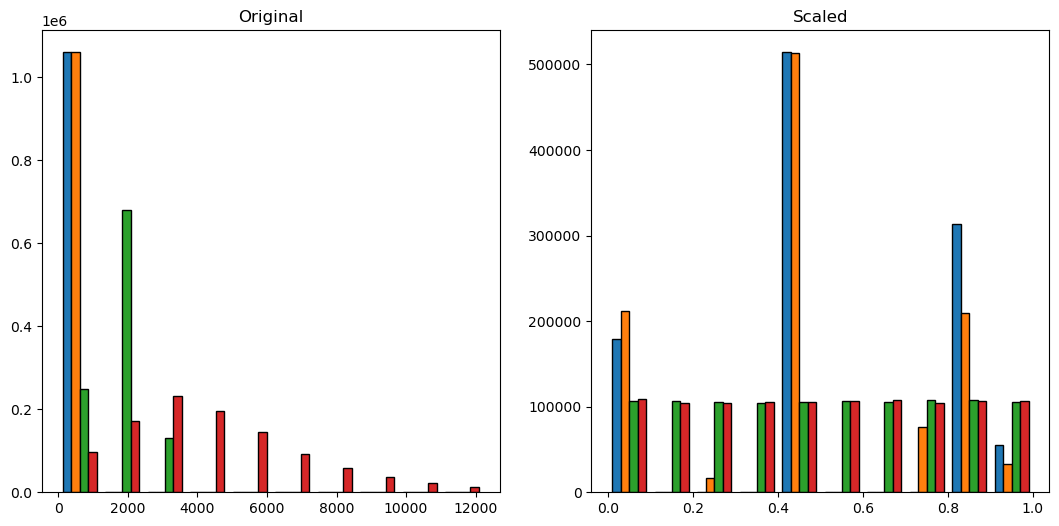

In [24]:
#Use the QuantileTransformer, but omit the output_distribution argument. 
#Visualize your results. What do you notice?

qt_scaler=QuantileTransformer()

qt_scaler.fit(scale_feats)

scale_feats_scaled = qt_scaler.transform(scale_feats)

plt.figure(figsize=(13, 6))
plt.subplot(121)
plt.hist(scale_feats, bins=10, ec='black')
plt.title('Original')
plt.subplot(122)
plt.hist(scale_feats_scaled, bins=10, ec='black')
plt.title('Scaled')

In [36]:
#Based on the work you've done, choose a scaling method for your dataset. 
#Write a function within your prepare.py that accepts as input the train, validate, and 
#test data splits, and returns the scaled versions of each. 
#Be sure to only learn the parameters for scaling from your training data!

def scale_data(t, v, te):
    ss_scaler = sklearn.preprocessing.StandardScaler()
    ss_scaler.fit(t)
    
    st=train_scaled = ss_scaler.transform(t)
    sv=validate_scaled = ss_scaler.transform(v)
    ste=test_scaled = ss_scaler.transform(te)

    return st, sv, ste

In [37]:
sc_train, sc_val, sc_test= scale_data(z_train, z_val, z_test)

In [38]:
sc_train

array([[ 0.98016271, -0.11684437, -0.85804964, ..., -0.30970549,
        -0.5392819 , -0.55604573],
       [-0.29265313,  0.57284729,  0.86983448, ...,  0.28308776,
         0.80038339,  0.51526777],
       [ 0.98016271, -0.11684437,  0.0680828 , ..., -0.0627083 ,
         0.47956857, -0.55604573],
       ...,
       [-0.29265313, -0.11684437, -0.89334689, ..., -0.35910492,
        -1.4197424 , -0.55604573],
       [-0.29265313,  0.57284729, -0.55550184, ..., -0.26030605,
        -0.31336436,  0.51526777],
       [ 0.98016271,  1.26253894,  1.58586428, ...,  2.25906526,
        -0.12036187, -0.55604573]])

In [39]:
sc_val

array([[ 0.98016271, -0.11684437,  0.49164973, ..., -1.19889536,
        -0.65282357, -0.55604573],
       [ 2.25297855,  2.64192226,  1.53543965, ...,  0.13488945,
         0.63747525, -0.55604573],
       [ 0.98016271,  1.26253894,  0.80596328, ...,  0.48068551,
        -1.07078979, -0.55604573],
       ...,
       [-0.29265313, -0.11684437,  1.0143851 , ...,  1.17227764,
        -0.30254213, -0.55604573],
       [-0.29265313, -0.11684437, -0.88494278, ..., -0.35910492,
        -0.3019144 , -0.55604573],
       [ 0.98016271,  1.26253894,  1.41610135, ...,  0.13488945,
         0.39357773, -0.55604573]])

In [40]:
sc_test

array([[-1.56546898, -0.11684437,  0.09833758, ..., -2.23628355,
         0.0798106 , -0.55604573],
       [ 0.98016271, -0.11684437,  0.04791295, ..., -0.26030605,
         0.59832774, -0.55604573],
       [-0.29265313, -1.49622768, -0.56558677, ..., -0.50730324,
        -0.42178228, -0.55604573],
       ...,
       [-0.29265313,  1.26253894, -0.28152799, ..., -0.16150717,
         0.74736875, -0.55604573],
       [-0.29265313, -1.49622768, -1.19085223, ..., -1.89048748,
        -0.1852993 , -0.55604573],
       [-1.56546898, -1.49622768, -1.0294934 , ..., -1.69288973,
         0.08506071, -0.55604573]])

In [41]:
sc_train.shape

(1060438, 7)